In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.multioutput import MultiOutputRegressor

In [54]:
df = pd.read_csv("m_sand_concrete_dataset.csv")

In [65]:
df = df.copy()
iso = IsolationForest(contamination=0.1, random_state=42)

X_features = df.drop(columns=["Compressive_strength", "CPC"])
outlier_pred = iso.fit_predict(X_features)

df_clean = df[outlier_pred == 1].reset_index(drop=True)
print("Shape original:", df.shape)
print("Shape after remove outlier:", df_clean.shape)

Shape original: (86, 8)
Shape after remove outlier: (77, 8)


In [56]:
X = df_clean.iloc[:, :6].values   # feature
y = df_clean.iloc[:, 6:].values   # label

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [57]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR

svr_base = Pipeline([
    ("scaler", StandardScaler()),
    ("svr", SVR(kernel='rbf'))
])

multi_svr = MultiOutputRegressor(svr_base)

param_dist = {
    "estimator__svr__C": [0.1, 1, 5, 10, 20, 50, 100],
    "estimator__svr__epsilon": [0.001, 0.01, 0.05, 0.1, 0.2],
    "estimator__svr__gamma": ["scale", "auto", 0.001, 0.01, 0.1, 1]
}

kf = KFold(n_splits=10, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    estimator=multi_svr,
    param_distributions=param_dist,
    n_iter=20,
    cv=kf,
    scoring="r2",
    n_jobs=-1,
    random_state=42,
    verbose=1
)

In [58]:
search.fit(X_train, y_train)

print("Best params:", search.best_params_)
print("Best CV R²:", search.best_score_)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best params: {'estimator__svr__gamma': 0.01, 'estimator__svr__epsilon': 0.05, 'estimator__svr__C': 50}
Best CV R²: 0.667521167456079


In [59]:
search.best_estimator_

,estimator,Pipeline(step...gamma=0.01))])
,n_jobs,None
,copy,True
,with_mean,True
,with_std,True
,kernel,'rbf'
,degree,3
,gamma,0.01
,coef0,0.0
,tol,0.001
,C,50


In [60]:
def calc_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return r2, rmse
    
y_pred_train = search.predict(X_train)
y_pred_test = search.predict(X_test)

# CS
r2_cs_train, rmse_cs_train = calc_metrics(y_train[:,0], y_pred_train[:,0])
r2_cs_test,  rmse_cs_test  = calc_metrics(y_test[:,0],  y_pred_test[:,0])

# CPC
r2_cpc_train, rmse_cpc_train = calc_metrics(y_train[:,1], y_pred_train[:,1])
r2_cpc_test,  rmse_cpc_test  = calc_metrics(y_test[:,1],  y_pred_test[:,1])

print("Train:")
print(f"CS  - R²: {r2_cs_train:.3f}, RMSE: {rmse_cs_train:.3f}")
print(f"CPC - R²: {r2_cpc_train:.3f}, RMSE: {rmse_cpc_train:.3f}")

print("Test:")
print(f"CS  - R²: {r2_cs_test:.3f}, RMSE: {rmse_cs_test:.3f}")
print(f"CPC - R²: {r2_cpc_test:.3f}, RMSE: {rmse_cpc_test:.3f}")

Train:
CS  - R²: 0.885, RMSE: 5.186
CPC - R²: 0.895, RMSE: 2.722
Test:
CS  - R²: 0.911, RMSE: 6.611
CPC - R²: 0.868, RMSE: 3.162


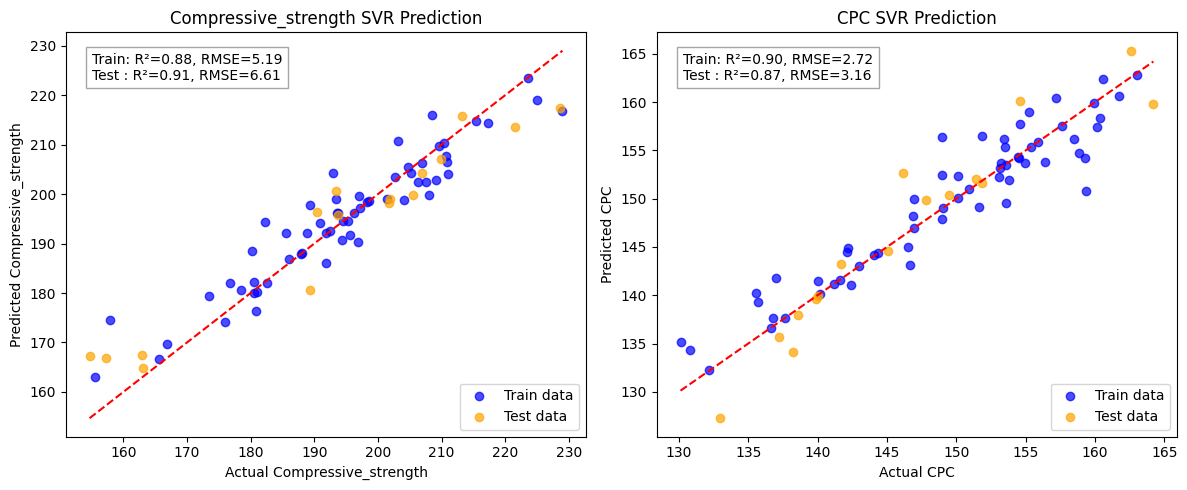

In [64]:
plt.figure(figsize=(12,5))
model_name = "SVR"

# Compressive Strength
plt.subplot(1,2,1)
plt.scatter(y_train[:,0], y_pred_train[:,0], alpha=0.7, color="blue", label="Train data")
plt.scatter(y_test[:,0], y_pred_test[:,0], alpha=0.7, color="orange", label="Test data")
plt.plot([min(y_train[:,0].min(), y_test[:,0].min()),
          max(y_train[:,0].max(), y_test[:,0].max())],
         [min(y_train[:,0].min(), y_test[:,0].min()),
          max(y_train[:,0].max(), y_test[:,0].max())], 'r--')
plt.text(0.05, 0.95,
         f"Train: R²={r2_cs_train:.2f}, RMSE={rmse_cs_train:.2f}\n"
         f"Test : R²={r2_cs_test:.2f}, RMSE={rmse_cs_test:.2f}",
         transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top',
         bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))
plt.xlabel("Actual Compressive_strength")
plt.ylabel("Predicted Compressive_strength")
plt.title(f"Compressive_strength {model_name} Prediction")
plt.legend()

# CPC
plt.subplot(1,2,2)
plt.scatter(y_train[:,1], y_pred_train[:,1], alpha=0.7, color="blue", label="Train data")
plt.scatter(y_test[:,1], y_pred_test[:,1], alpha=0.7, color="orange", label="Test data")
plt.plot([min(y_train[:,1].min(), y_test[:,1].min()),
          max(y_train[:,1].max(), y_test[:,1].max())],
         [min(y_train[:,1].min(), y_test[:,1].min()),
          max(y_train[:,1].max(), y_test[:,1].max())], 'r--')
plt.text(0.05, 0.95,
         f"Train: R²={r2_cpc_train:.2f}, RMSE={rmse_cpc_train:.2f}\n"
         f"Test : R²={r2_cpc_test:.2f}, RMSE={rmse_cpc_test:.2f}",
         transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top',
         bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))
plt.xlabel("Actual CPC")
plt.ylabel("Predicted CPC")
plt.title(f"CPC {model_name} Prediction")
plt.legend()

plt.tight_layout()
plt.show()

In [62]:
import pickle
with open("best_SVR_model.pkl", "wb") as f:
    pickle.dump(search.best_estimator_, f)

# with open("best_xgb_model.pkl", "rb") as f:
#     loaded_model = pickle.load(f)